## IBM Data Science Professional Certificate<br>Applied Data Science  |  Capstone project
# Car accident severity
### Isabel Almeida<br>September 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 1. Introduction

### Business Problem / Business Understanding

Vehicle collisions can be costly not just to those involved, but to society as a whole. Besides financial expenditures, costs to individuals and families can be considerable, especially in cases with severe injuries or fatalities. With hundreds of thousands of vehicle collisions registered anually, it is important to analyze the conditions under which they occur so that the public and policy makers can take action.

To help with such understanding, by using machine learning techniques this study attempts to predict the severity of vehicle collisions in the city of Seattle based on observable conditions. In this way, both individuals and traffic monitors can become more alert when relevant conditions are present and take preventative measures to avoid further accidents.

# 2. Data

The example dataset of collisions in Seattle city, provided in Week 1 of the Capstone Project syllabus, will be used in this project.

### Data understanding / Data preparation

The metadata for the Seattle collision dataset can be found [here](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf).<br>
Let's have a first look at the dataset.

In [2]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('Data-Collisions.csv',
                 # "INCDTTM" was formatted as datetime after further analysis in the next sections.
                 parse_dates = ['INCDTTM'])
df

/opt/miniconda3/envs/ds376/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,,NaN,2,Injury Collision,Angles,2,0,0,2,2013/03/27 00:00:00+00,2013-03-27 14:54:00,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006/12/20 00:00:00+00,2006-12-20 18:55:00,Mid-Block (not related to intersection),16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004/11/18 00:00:00+00,2004-11-18 10:20:00,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,2ND AVE BETWEEN MARION ST AND MADISON ST,,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013/03/29 00:00:00+00,2013-03-29 09:26:00,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,SWIFT AVE S AND SWIFT AV OFF RP,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2004/01/28 00:00:00+00,2004-01-28 08:04:00,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,2,-122.290826,47.565408,219543,309534,310814,E871089,Matched,Block,NaN,34TH AVE S BETWEEN S DAKOTA ST AND S GENESEE ST,,NaN,2,Injury Collision,Head On,3,0,0,2,2018/11/12 00:00:00+00,2018-11-12 08:12:00,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,24,From opposite direction - both moving - head-on,0,0,N
194669,1,-122.344526,47.690924,219544,309085,310365,E876731,Matched,Block,NaN,AURORA AVE N BETWEEN N 85TH ST AND N 86TH ST,,NaN,1,Property Damage Only Collision,Rear Ended,2,0,0,2,2018/12/18 00:00:00+00,2018-12-18 09:14:00,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",Y,N,Raining,Wet,Daylight,NaN,NaN,NaN,13,From same direction - both going straight - bo...,0,0,N
194670,2,-122.306689,47.683047,219545,311280,312640,3809984,Matched,Intersection,24760.0,20TH AVE NE AND NE 75TH ST,,NaN,2,Injury Collision,Left Turn,3,0,0,2,2019/01/19 00:00:00+00,2019-01-19 09:25:00,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,28,From opposite direction - one left turn - one ...,0,0,N
194671,2,-122.355317,47.678734,219546,309514,310794,3810083,Matched,Intersection,24349.0,GREENWOOD AVE N AND N 68TH ST,,NaN,2,Injury Collision,Cycles,2,0,1,1,2019/01/15 00:00:00+00,2019-01-15 16:48:00,At Intersection (intersection related),51,PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT...,NaN,N,Clear,Dry,Dusk,NaN,NaN,NaN,5,Vehicle Strikes Pedalcyclist,4308,0,

The dataset contains 194,673 collision records with 38 attributes.<br>
<br>
Because the objective of this project is to guess the severity of a crash based on other available data, we know immediately that our target variable (dependent feature) is "SEVERITYCODE". According to the metadata documentation, it is a categorical variable with 5 possible values. We will check the actual range of values for "SEVERITYCODE" in this dataset in the sections ahead.<br>
<br>
Because our dependent feature is categorical, that is, it can only assume one of a discrete number of classes, we already know our project will be featuring a classification machine learning model.<br>
<br>
A quick look at the table makes it clear that the data in the example dataset and the dataset referenced in the metadata documentation are slightly different: some of the columns exist in one, but not in the other, and vice-versa.<br>
Columns without a corresponding description in the metadata documentation and an unclear purpose will be deleted, as there is no way to check exactly what information they hold. Columns with seemingly irrelevant or redundant information will also be deleted.<br>
<br>
When isolating the time (HH:MM:SS) from the datetime column "INCDTTM" and checking its unique value counts, 16% of collisions are recorded as having occurred at exactly 00:00:00. This is likely a workaround for collisions where the time of the event is unknown, and such records will be replaced by 999:00:00, which will serve as the numeric equivalent to "Unspecified".<br>
<br>
Moreover, the "INCDTTM" column contains date and time information for each collision. Because we only wish to use bits of this information in our model, it will be split and replaced by three attributes: "Month", "Weekday" and "Hour".

In [4]:
# Replacing 00:00:00 timestamps with 999:00:00:
df['hour_hms'] = df['INCDTTM'].dt.strftime('%X')
df['hour_hms'].replace({'00:00:00': '999:00:00'}, inplace=True)

# Splitting the "INCDTTM" column into additional attributes for the model:
df['Month'] = df['INCDTTM'].dt.month
df['Weekday'] = df['INCDTTM'].dt.dayofweek
hour_split = df['hour_hms'].str.split(":",n=1,expand=True)
df['Hour'] = hour_split[0]
df['Hour'] = pd.to_numeric(df['Hour'], errors='coerce')

df = df.drop(
    # Datetime columns replaced by the three attributes above:
    ['INCDTTM', 'hour_hms',
    
    # Columns with no corresponding description in metadata documentation and purpose is unclear: 
    "REPORTNO", "STATUS", "EXCEPTRSNCODE", "EXCEPTRSNDESC",
     
    # Columns with seemingly irrelevant or redundant information:
    "OBJECTID", "INCKEY", "COLDETKEY", "INTKEY", "LOCATION", "SEVERITYCODE.1", "SEVERITYDESC", "INCDATE", 
    "SDOT_COLDESC", "SDOTCOLNUM", "ST_COLDESC", "SEGLANEKEY", "CROSSWALKKEY",
    
    # Column dropped due to insufficient metadata documentation, seen in further analysis in the next sections:
     "UNDERINFL"], 
    
    axis=1)

# Turning all numbers stored as strings in "ST_COLCODE" into numeric data type:
df['ST_COLCODE'] = pd.to_numeric(df['ST_COLCODE'], errors='coerce')

# Categorical columns where NaN will be replaced by "Unknown", seen in further analysis in the next sections:
cols1=['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','WEATHER','ROADCOND','LIGHTCOND']
df[cols1] = df[cols1].fillna('Unknown')

# Categorical columns where NaN will be replaced by "N", seen in further analysis in the next sections:
cols2=['INATTENTIONIND','PEDROWNOTGRNT','SPEEDING']
df[cols2] = df[cols2].fillna('N')

# Coordinate columns where NaN will be replaced by 999, seen in further analysis in the next sections:
cols3=['X','Y','ST_COLCODE']
df[cols3] = df[cols3].fillna(999)

df

,SEVERITYCODE,X,Y,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE,SDOT_COLCODE,INATTENTIONIND,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,HITPARKEDCAR,Month,Weekday,Hour
0,2,-122.323148,47.703140,Intersection,Angles,2,0,0,2,At Intersection (intersection related),11,N,Overcast,Wet,Daylight,N,N,10.0,N,3,2,14
1,1,-122.347294,47.647172,Block,Sideswipe,2,0,0,2,Mid-Block (not related to intersection),16,N,Raining,Wet,Dark - Street Lights On,N,N,11.0,N,12,2,18
2,1,-122.334540,47.607871,Block,Parked Car,4,0,0,3,Mid-Block (not related to intersection),14,N,Overcast,Dry,Daylight,N,N,32.0,N,11,3,10
3,1,-122.334803,47.604803,Block,Other,3,0,0,3,Mid-Block (not related to intersection),11,N,Clear,Dry,Daylight,N,N,23.0,N,3,4,9
4,2,-122.306426,47.545739,Intersection,Angles,2,0,0,2,At Intersection (intersection related),11,N,Raining,Wet,Daylight,N,N,10.0,N,1,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,2,-122.290826,47.565408,Block,Head On,3,0,0,2,Mid-Block (not related to intersection),11,N,Clear,Dry,Daylight,N,N,24.0,N,11,0,8
194669,1,-122.344526,47.690924,Block,Rear Ended,2,0,0,2,Mid-Block (not related to intersection),14,Y,Raining,Wet,Daylight,N,N,13.0,N,12,1,9
194670,2,-122.306689,47.683047,Intersection,Left Turn,3,0,0,2,At Intersection (intersection related),11,N,Clear,Dry,Daylight,N,N,28.0,N,1,5,9
194671,2,-122.355317,47.678734,Intersection,Cycles,2,0,1,1,At Intersection (intersection related),51,N,Clear,Dry,Dusk,N,N,5.0,N,1,1,16


The same 194,673 records remain but now we are only working with 22 attributes.<br>
<br>
Let's have a look at the unique values in each of the remaining columns.

In [5]:
for column in df.columns:
     print("Name: ",column,"\n",
           "Data type: ",df[column].dtype,"\n\n",
           "Value count:","\n",
           df[column].value_counts(dropna=False),"\n\n",
           "Value frequency:","\n",
           df[column].value_counts(dropna=False, normalize=True),"\n\n\n",)

Name:  SEVERITYCODE 
 Data type:  int64 

 Value count: 
 1    136485
2     58188
Name: SEVERITYCODE, dtype: int64 

 Value frequency: 
 1    0.701099
2    0.298901
Name: SEVERITYCODE, dtype: float64 



Name:  X 
 Data type:  float64 

 Value count: 
  999.000000    5334
-122.332653     265
-122.344896     254
-122.328079     252
-122.344997     239
               ... 
-122.322768       1
-122.288680       1
-122.405699       1
-122.323578       1
-122.343898       1
Name: X, Length: 23564, dtype: int64 

 Value frequency: 
  999.000000    0.027400
-122.332653    0.001361
-122.344896    0.001305
-122.328079    0.001294
-122.344997    0.001228
                 ...   
-122.322768    0.000005
-122.288680    0.000005
-122.405699    0.000005
-122.323578    0.000005
-122.343898    0.000005
Name: X, Length: 23564, dtype: float64 



Name:  Y 
 Data type:  float64 

 Value count: 
 999.000000    5334
47.708655      265
47.717173      254
47.604161      252
47.725036      239
              ...

Name:  PEDROWNOTGRNT 
 Data type:  object 

 Value count: 
 N    190006
Y      4667
Name: PEDROWNOTGRNT, dtype: int64 

 Value frequency: 
 N    0.976026
Y    0.023974
Name: PEDROWNOTGRNT, dtype: float64 



Name:  SPEEDING 
 Data type:  object 

 Value count: 
 N    185340
Y      9333
Name: SPEEDING, dtype: int64 

 Value frequency: 
 N    0.952058
Y    0.047942
Name: SPEEDING, dtype: float64 



Name:  ST_COLCODE 
 Data type:  float64 

 Value count: 
 32.0    44421
10.0    34674
14.0    25771
50.0    13554
11.0    12777
        ...  
43.0        2
87.0        2
60.0        1
85.0        1
49.0        1
Name: ST_COLCODE, Length: 63, dtype: int64 

 Value frequency: 
 32.0    0.228183
10.0    0.178114
14.0    0.132381
50.0    0.069624
11.0    0.065633
          ...   
43.0    0.000010
87.0    0.000010
60.0    0.000005
85.0    0.000005
49.0    0.000005
Name: ST_COLCODE, Length: 63, dtype: float64 



Name:  HITPARKEDCAR 
 Data type:  object 

 Value count: 
 N    187457
Y      7216
Nam

The attribute "UNDERINFL", which is meant to be a categorical Y/N variable, shows additional "0" and "1" values with no corresponding explanation in the metadata documentation. To avoid misinterpretations, this column will also be dropped from our dataset (code in previous cells adjusted).<br>
<br>
All data types seem to match except for "ST_COLCODE", meant to be purely numeric as it refers to a code, but shown as an object type. The column will be converted to integer (code in previous cells adjusted).<br>
<br>
We also have a number of NaN values. For categorical attributes, they will be replaced by "Unknown" or "No" according to the nature of the information in a given column. For columns X and Y, the coordinates for the location of each collision, NaN values will be replaced by 999, which is out of the valid range for both latitude and longitude. NaN values in "ST_COLCODE"'s will also be replaced by 999, which is out of the collision code range as well (code in previous cells adjusted).<br>
<br>
Although the metadata described 5 possible values for "SEVERITYCODE", this dataset contains only 2, meaning our target variable is binary. This may affect the choice of algorithm to complete this project, which will be discussed in the appropriate section further ahead.

We notice that "SEVERITYCODE" is unbalanced, with 70% of values belonging to category 1 and 30% to category 2. This will be addressed in the modeling phase, where after the data is split into training and testing sets, the training set's category 1 values will be undersampled.

### Exploratory Data Analysis (WIP)

Let's plot some of the columns to visualize the data.

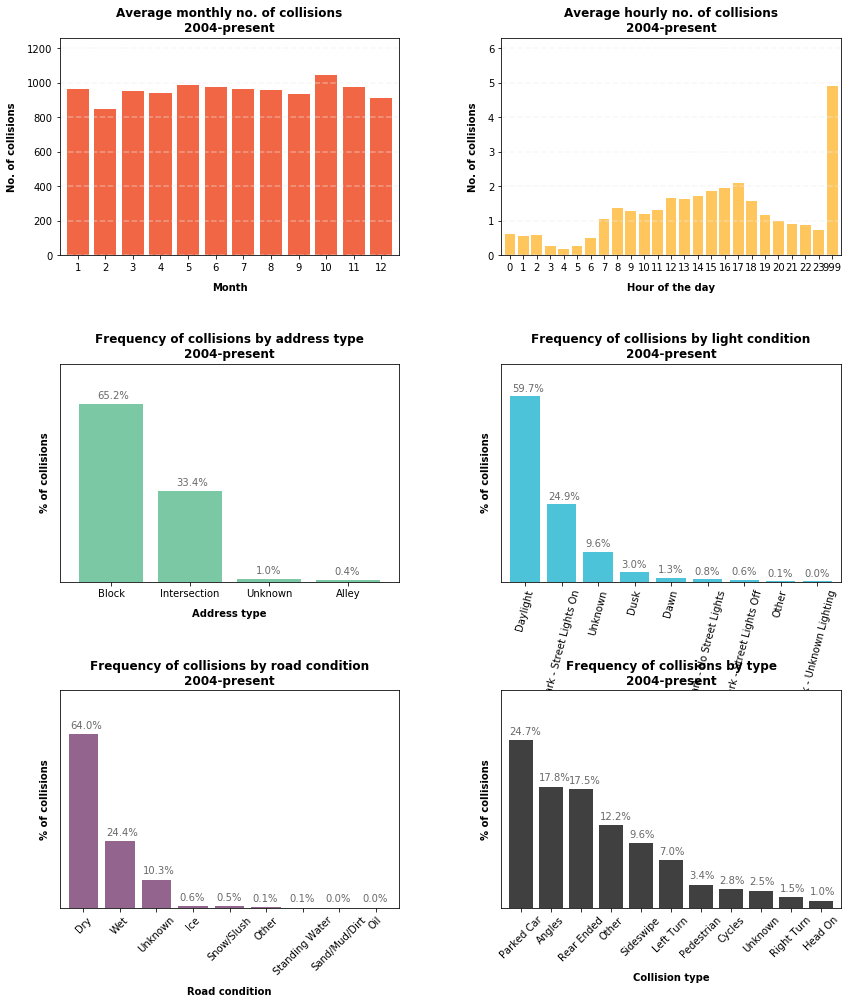

In [6]:
fig = plt.figure(figsize=(14,16))

# Average monthly no. of collisions in Seattle
ax1 = fig.add_subplot(3,2,1)
plot_df = df.groupby(df['Month'])['SEVERITYCODE'].agg(['count']).div(2020-2003)
plot_df.plot(ax=ax1, kind='bar', color='#F16745', width=0.8, rot=0, legend=False)
ax1.set_xlabel('Month', weight='bold', labelpad=10)
ax1.set_ylabel('No. of collisions', weight='bold', labelpad=10)
ax1.set_title('Average monthly no. of collisions\n2004-present', weight='bold', size=12)
# Drawing lines for the y ticks:
vals = ax1.get_yticks()
for tick in vals:
    ax1.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    
# Average hourly no. of collisions in Seattle
ax2 = fig.add_subplot(3,2,2)
plot_df = df.groupby(df['Hour'])['SEVERITYCODE'].agg(['count']).div((2020-2003)*365)
plot_df.plot(ax=ax2, kind='bar', color='#FFC65D', rot=0, width=0.8, legend=False)
ax2.set_xlabel('Hour of the day', weight='bold', labelpad=10)
ax2.set_ylabel('No. of collisions', weight='bold', labelpad=10)
ax2.set_title('Average hourly no. of collisions\n2004-present', weight='bold', size=12)
vals = ax2.get_yticks()
for tick in vals:
    ax2.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Address type
ax3 = fig.add_subplot(3,2,3)
plot_df = df.groupby(df['ADDRTYPE'])['SEVERITYCODE'].agg(['count']).div(len(df['SEVERITYCODE'])).sort_values(['count'],ascending=False)
plot_df.plot(ax=ax3, kind='bar', color='#7BC8A4', rot=0, width=0.8, legend=False)
ax3.set_xlabel('Address type', weight='bold', labelpad=10)
ax3.set_ylabel('% of collisions', weight='bold', labelpad=10)
ax3.set_ylim(0,0.8)
ax3.axes.yaxis.set_ticks([])
ax3.set_title('Frequency of collisions by address type\n2004-present', weight='bold', size=12)
# Labeling each bar:
totals = []
for i in ax3.patches:
    totals.append(i.get_height())
total = sum(totals)
for i in ax3.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax3.text(i.get_x()+.23, i.get_height()+.02, \
            str(round((i.get_height())*100, 1))+'%', fontsize=10,
                color='dimgrey')
    
# Light conditions
ax4 = fig.add_subplot(3,2,4)
plot_df = df.groupby(df['LIGHTCOND'])['SEVERITYCODE'].agg(['count']).div(len(df['SEVERITYCODE'])).sort_values(['count'],ascending=False)
plot_df.plot(ax=ax4, kind='bar', color='#4CC3D9', rot=75, width=0.8, legend=False)
ax4.set_xlabel('Light condition', weight='bold', labelpad=10)
ax4.set_ylabel('% of collisions', weight='bold', labelpad=10)
ax4.set_ylim(0,0.7)
ax4.axes.yaxis.set_ticks([])
ax4.set_title('Frequency of collisions by light condition\n2004-present', weight='bold', size=12)
totals = []
for i in ax4.patches:
    totals.append(i.get_height())
total = sum(totals)
for i in ax4.patches:
    ax4.text(i.get_x()+.04, i.get_height()+.015, \
            str(round((i.get_height())*100, 1))+'%', fontsize=10,
                color='dimgrey')
    
# Road conditions
ax5 = fig.add_subplot(3,2,5)
plot_df = df.groupby(df['ROADCOND'])['SEVERITYCODE'].agg(['count']).div(len(df['SEVERITYCODE'])).sort_values(['count'],ascending=False)
plot_df.plot(ax=ax5, kind='bar', color='#93648D', rot=45, width=0.8, legend=False)
ax5.set_xlabel('Road condition', weight='bold', labelpad=10)
ax5.set_ylabel('% of collisions', weight='bold', labelpad=10)
ax5.set_ylim(0,0.8)
ax5.axes.yaxis.set_ticks([])
ax5.set_title('Frequency of collisions by road condition\n2004-present', weight='bold', size=12)
totals = []
for i in ax5.patches:
    totals.append(i.get_height())
total = sum(totals)
for i in ax5.patches:
    ax5.text(i.get_x()+.03, i.get_height()+.02, \
            str(round((i.get_height())*100, 1))+'%', fontsize=10,
                color='dimgrey')
    
# Collision type
ax6 = fig.add_subplot(3,2,6)
plot_df = df.groupby(df['COLLISIONTYPE'])['SEVERITYCODE'].agg(['count']).div(len(df['SEVERITYCODE'])).sort_values(['count'],ascending=False)
plot_df.plot(ax=ax6, kind='bar', color='#404040', rot=45, width=0.8, legend=False)
ax6.set_xlabel('Collision type', weight='bold', labelpad=10)
ax6.set_ylabel('% of collisions', weight='bold', labelpad=10)
ax6.set_ylim(0,0.32)
ax6.axes.yaxis.set_ticks([])
ax6.set_title('Frequency of collisions by type\n2004-present', weight='bold', size=12)
totals = []
for i in ax6.patches:
    totals.append(i.get_height())
total = sum(totals)
for i in ax6.patches:
    ax6.text(i.get_x()+.015, i.get_height()+.008, \
            str(round((i.get_height())*100, 1))+'%', fontsize=10,
                color='dimgrey')
    
fig.subplots_adjust(wspace=0.3,hspace=0.5)

# 3. Model (WIP)

Most of the attributes are categorical. To be able to run them into any chosen model, we will transform them into quantitative variables.

In [7]:
cat_columns = df.select_dtypes(['object'])
encoding_maps = []

for column in cat_columns:
    column_series = cat_columns[column]
    unique_values = column_series.unique()
    column_labels = le.fit_transform(column_series)
    column_mappings = {index: label for index, label in 
                  enumerate(le.classes_)}
    encoding_maps.append(column_mappings)
    df[column] = column_labels

print(*encoding_maps,sep = "\n\n")

{0: 'Alley', 1: 'Block', 2: 'Intersection', 3: 'Unknown'}

{0: 'Angles', 1: 'Cycles', 2: 'Head On', 3: 'Left Turn', 4: 'Other', 5: 'Parked Car', 6: 'Pedestrian', 7: 'Rear Ended', 8: 'Right Turn', 9: 'Sideswipe', 10: 'Unknown'}

{0: 'At Intersection (but not related to intersection)', 1: 'At Intersection (intersection related)', 2: 'Driveway Junction', 3: 'Mid-Block (but intersection related)', 4: 'Mid-Block (not related to intersection)', 5: 'Ramp Junction', 6: 'Unknown'}

{0: 'N', 1: 'Y'}

{0: 'Blowing Sand/Dirt', 1: 'Clear', 2: 'Fog/Smog/Smoke', 3: 'Other', 4: 'Overcast', 5: 'Partly Cloudy', 6: 'Raining', 7: 'Severe Crosswind', 8: 'Sleet/Hail/Freezing Rain', 9: 'Snowing', 10: 'Unknown'}

{0: 'Dry', 1: 'Ice', 2: 'Oil', 3: 'Other', 4: 'Sand/Mud/Dirt', 5: 'Snow/Slush', 6: 'Standing Water', 7: 'Unknown', 8: 'Wet'}

{0: 'Dark - No Street Lights', 1: 'Dark - Street Lights Off', 2: 'Dark - Street Lights On', 3: 'Dark - Unknown Lighting', 4: 'Dawn', 5: 'Daylight', 6: 'Dusk', 7: 'Other', 8: '

In [8]:
df

,SEVERITYCODE,X,Y,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE,SDOT_COLCODE,INATTENTIONIND,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,HITPARKEDCAR,Month,Weekday,Hour
0,2,-122.323148,47.703140,2,0,2,0,0,2,1,11,0,4,8,5,0,0,10.0,0,3,2,14
1,1,-122.347294,47.647172,1,9,2,0,0,2,4,16,0,6,8,2,0,0,11.0,0,12,2,18
2,1,-122.334540,47.607871,1,5,4,0,0,3,4,14,0,4,0,5,0,0,32.0,0,11,3,10
3,1,-122.334803,47.604803,1,4,3,0,0,3,4,11,0,1,0,5,0,0,23.0,0,3,4,9
4,2,-122.306426,47.545739,2,0,2,0,0,2,1,11,0,6,8,5,0,0,10.0,0,1,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,2,-122.290826,47.565408,1,2,3,0,0,2,4,11,0,1,0,5,0,0,24.0,0,11,0,8
194669,1,-122.344526,47.690924,1,7,2,0,0,2,4,14,1,6,8,5,0,0,13.0,0,12,1,9
194670,2,-122.306689,47.683047,2,3,3,0,0,2,1,11,0,1,0,5,0,0,28.0,0,1,5,9
194671,2,-122.355317,47.678734,2,1,2,0,1,1,1,51,0,1,0,6,0,0,5.0,0,1,1,16
